In [84]:
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from tqdm import tqdm
from sklearn.metrics.pairwise import pairwise_distances

import operator
import skimage.io as io
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
import torchvision.transforms as transforms
import torch
from torch import nn
from torch.autograd import Variable
import pickle

import string
import os

from collections import defaultdict


In [85]:
imagesDir = './photo/'
dataDir = '../coco_dataset/'
annTrainFile = '{}annotations/captions_train2017.json'.format(dataDir)

In [86]:
def bleu(reference, candidat, n, eps=1e-5):
    ref = list(reference.split())
    cand = list(candidat.split())
    score = 0
    
    for i in range(1, n + 1):
        ref_dict = defaultdict(int)
        cand_dict = defaultdict(int)
        
        for j in range(i, len(ref) + 1):
            ref_dict[' '.join(ref[j - i:j])] += 1
        
        for j in range(i, len(cand) + 1):
            cand_dict[' '.join(cand[j - i:j])] += 1
        
        if len(cand_dict) == 0 or len(ref_dict) == 0:
            raise SyntaxError('\rError: Count of words is less than n')
        
        sum_ = 0
        all_ = 0
        for key in cand_dict.keys():
            sum_ += min(cand_dict[key], ref_dict[key])
            all_ += cand_dict[key]
        
        score += np.log(float(sum_) / all_ + eps)
    
    score = np.exp(score / n)
    if len(cand) < len(ref):
        score *= np.exp(1 - float(len(ref)) / len(cand))
    return score

In [87]:
def tokenize(s):
    s = s.lower()
    for t in string.punctuation: 
        s = s.replace(t, ' ')
    return s


def numpy2image(img_numpy):
    if img_numpy.dtype == np.dtype('float64'):
        img_numpy = (img_numpy*255).astype('uint8')
    return Image.fromarray(img_numpy)


class MSCOCODataset(Dataset):
    """MSCOCO Dataset"""

    def __init__(self, imagesDir, transform=None):
        self.imagesDir = imagesDir
        self.transform = transform
        self.list_dir = [] 
        for name in os.listdir(self.imagesDir):
            if '.jpg' in name or '.jpeg' in name:
                self.list_dir.append(name)

    def __len__(self):
        return len(self.list_dir)

    def __getitem__(self, idx):
        image = io.imread(self.imagesDir + self.list_dir[idx])
        
        if len(image.shape) != 3:
            return self.__getitem__(0)
        
        image = numpy2image(image)
        if self.transform is not None:
            image = self.transform(image)
            
        sample = {'image': image, 'id': idx}
            
        return sample

In [88]:
class KNN:
    def __init__(self, k, coco, model):
        '''
        k: int, count of nearest neighborhood
        coco: COCO(annTrainFile), annTrainFile - file with annotations of train dataset
        model: torchvision.models, pretrained classifier model
        pretrained: bool, if True load converted images for files
        '''
        self.k = k
        self.coco = coco
        self.cnn = model
        self.mertric = bleu
       
    def images2vec(self, loader):
        '''
        Convert each image in vector(torch array)
        loader: Dataloader(MSCOCODataset)       
        return: (torch.array, torch.array)
        '''
        assert len(loader) != 0
        
        res = None
        res_ids = None
        for i, item in tqdm(enumerate(loader)):
            
            X = Variable(item['image'].type(torch.FloatTensor))
            ids = item['id']
            
            vec = self.cnn.forward(X).data
            vec = vec.view(vec.size(0), -1)
            
            if res is None:
                res = vec
                res_ids = ids
            else:
                res = torch.cat((res, vec), 0)
                res_ids = torch.cat((res_ids, ids), 0)
                
        return res, res_ids
            
    def predict(self, test_loader):
        '''
        Create pretrained dataset for algorithm
        train_loader: Dataloader(MSCOCODataset)
        test_loader: Dataloader(MSCOCODataset)
        return: dict, key is <mscoco_id> of each image, value is annotation
        '''
        train_image = torch.load('./train_image_resnet.pth').numpy()
        train_image_id = torch.load('./train_image_ids_resnet.pth').numpy()
        
        test_image, test_image_id = self.images2vec(test_loader)
               
        print ("Congratulations! All images converted")
            
        pairs = pairwise_distances(test_image, train_image)                
        nearest_ids = np.zeros((test_image.shape[0], self.k))
        
        for i in range(self.k):
            ids = np.argmin(pairs, 1)
            nearest_ids[:, i] = ids[:]
            for i, idx in enumerate(ids):
                pairs[i, idx] = 10**3
        nearest_ids = nearest_ids.astype(np.int)
        
        res = defaultdict(list)
        for it in tqdm(range(nearest_ids.shape[0])):
            anns_ids = self.coco.getAnnIds(imgIds=train_image_id[nearest_ids[it]])
            anns = self.coco.loadAnns(anns_ids)
            anns = [ann['caption'] for ann in anns]
            dist_sim = np.zeros((len(anns), len(anns)))
            
            for i in range(len(anns)):
                for j in range(i + 1, len(anns)):

                    dist_sim[i][j] = self.mertric(tokenize(anns[i]), tokenize(anns[j]), 4)
                    dist_sim[j][i] = self.mertric(tokenize(anns[j]), tokenize(anns[i]), 4)
                    
            dist_sim_sum = dist_sim.sum(0)
            
            for t in range(3):
                res[int(test_image_id[it])].append(anns[np.argmax(dist_sim_sum)])
                dist_sim_sum[np.argmax(dist_sim_sum)] = -1.
            
        return res

In [89]:
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                             transforms.ToTensor(), 
                                             transforms.Normalize(
                                                 mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])])

test_dataset = MSCOCODataset(imagesDir, transform)

test_dataloader = DataLoader(test_dataset, batch_size=16)

cnn = models.resnet152(pretrained=True)
cnn = nn.Sequential(*list(cnn.children())[:-1])

In [90]:
m = KNN(20, COCO(annTrainFile), cnn)

loading annotations into memory...
Done (t=1.05s)
creating index...
index created!


In [91]:
res = m.predict(test_dataloader)


0it [00:00, ?it/s]
1it [00:01,  1.12s/it]


Congratulations! All images converted



100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


In [92]:
res

defaultdict(list,
            {0: ['a woman standing next to a car with bikes attached to the back of it ',
              'A woman standing next to a car with two bicycles attached to the back of it. ',
              'A motorcycle with a bicycle strapped to the back of it'],
             1: ['a group of people standing in a room playing a video game ',
              'A couple of people standing in front of a refrigerator.',
              'A man and a young woman sitting at a table in front of a chocolate cake.']})

KNN 0: a group of people standing in a room playing a video game 
KNN 1: A couple of people standing in front of a refrigerator.
KNN 2: A man and a young woman sitting at a table in front of a chocolate cake.


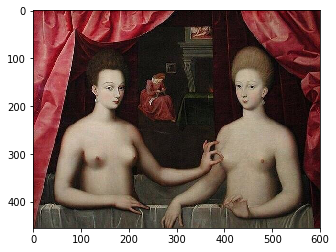

In [94]:
names = []
for name in os.listdir(imagesDir):
            if '.jpg' in name or '.jpeg' in name:
                names.append(name)
                
for i, name in enumerate(names):
    if i != 1:
        continue
    for t in range(len(res[i])):
        print('\rKNN {}: '.format(t) + res[i][t])
    im = io.imread('./photo/' + name)
    plt.imshow(im)
    break